# 06. Hybrid ANPR Pipeline (YOLO + Custom OCR)

**Architecture:**
1. **Detection** → YOLOv8 (Transfer Learning)
2. **Segmentation** → OpenCV Contours
3. **Recognition** → Custom CNN OCR

In [24]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model

## Load Models

In [25]:
# Load YOLO detector (Transfer Learning)
detector = YOLO('../models/yolo_plate_detector.pt')
print('Loaded YOLOv8 detector')

# Load custom OCR model (Your implementation)
ocr_model = load_model('../models/ocr_cnn.h5', compile=False)
print('Loaded custom OCR CNN')

# Load class names
class_names = sorted(os.listdir('../data/processed/train_ocr')) if os.path.exists('../data/processed/train_ocr') else []
print(f'OCR Classes ({len(class_names)}): {class_names}')

Loaded YOLOv8 detector
Loaded custom OCR CNN
OCR Classes (35): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Segmentation Function (Improved)

Uses adaptive thresholding with Otsu fallback for robust character segmentation.

In [26]:
def find_candidates(thresh, h_plate, debug_img=None):
    """Find character candidates using contours and filtering."""
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        ratio = h / w
        
        # Relaxed filters: h > 20% plate height, aspect ratio > 0.1
        if h > h_plate * 0.2 and h < h_plate * 0.95 and ratio > 0.1:
            candidates.append((x, y, w, h))
            if debug_img is not None:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        else:
            if debug_img is not None:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
    
    return candidates

def segment_characters(plate_img, debug=False):
    """Segment characters from plate image."""
    h_plate, w_plate = plate_img.shape[:2]
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    # Try Adaptive Thresholding first
    thresh_adapt = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh_adapt = cv2.morphologyEx(thresh_adapt, cv2.MORPH_CLOSE, kernel)
    
    candidates_adapt = find_candidates(thresh_adapt, h_plate)
    
    final_candidates = candidates_adapt
    method = "Adaptive"
    
    # Fallback to Otsu if too few or too many candidates
    if len(candidates_adapt) < 4 or len(candidates_adapt) > 12:
        _, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_otsu = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel)
        
        candidates_otsu = find_candidates(thresh_otsu, h_plate)
        
        # Use Otsu if it gives better results
        if 4 <= len(candidates_otsu) <= 12:
            final_candidates = candidates_otsu
            method = "Otsu"
        elif len(candidates_otsu) > len(candidates_adapt) and len(candidates_adapt) < 4:
            final_candidates = candidates_otsu
            method = "Otsu"
        elif len(candidates_otsu) < len(candidates_adapt) and len(candidates_adapt) > 12:
            final_candidates = candidates_otsu
            method = "Otsu"
    
    if debug:
        print(f'  Segmentation: {method} method, {len(final_candidates)} candidates')
    
    # Sort left to right
    bounding_boxes = sorted(final_candidates, key=lambda b: b[0])
    
    # Extract character ROIs
    char_rois = []
    for (x, y, w, h) in bounding_boxes:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (32, 32))
        char_rois.append(roi)
    
    return char_rois

## Hybrid Pipeline Function

In [ ]:
def predict_plate_hybrid(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    
    h_img, w_img = img.shape[:2]
    
    # --- 1. DETECCIÓN YOLO (Confianza baja para no perder nada) ---
    results = detector(img, conf=0.05, verbose=False)
    
    if len(results[0].boxes) == 0:
        print(f"No plate detected in {os.path.basename(image_path)}")
        return None

    # Buscar la mejor caja válida
    best_box = None
    max_conf = 0
    
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0].cpu().numpy())
        
        w_box = x2 - x1
        h_box = y2 - y1
        
        # FILTRO CRÍTICO: Si es más alta que ancha, es basura (como en images10.jpg)
        if h_box > w_box: continue 
        if w_box < 40: continue # Muy chica
        
        if conf > max_conf:
            max_conf = conf
            best_box = (x1, y1, x2, y2)
            
    if best_box is None: 
        print(f"Solo se detectó ruido en {os.path.basename(image_path)}")
        return None

    x1, y1, x2, y2 = best_box
    # Margen pequeño de seguridad para el recorte
    x1, y1 = max(0, x1-2), max(0, y1-2)
    x2, y2 = min(w_img, x2+2), min(h_img, y2+2)
    
    plate_crop = img[y1:y2, x1:x2]
    
    # --- 2. SEGMENTACIÓN (Adaptive Threshold - El más robusto) ---
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    char_crops = []
    plate_h = plate_crop.shape[0]
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filtros de tamaño para descartar ruido o bordes
        if h < plate_h * 0.35: continue # Muy chica
        if h > plate_h * 0.98: continue # Borde completo
        
        char_crops.append((x, y, w, h))
    
    char_crops.sort(key=lambda b: b[0]) # Ordenar izquierda a derecha
    
    # --- 3. RECONOCIMIENTO (Tu CNN) ---
    raw_text = ""
    
    for x, y, w, h in char_crops:
        # Usamos la imagen gris original recortada
        char_roi = gray[y:y+h, x:x+w] 
        
        # Preprocesamiento simple (Resize y normalización)
        input_char = cv2.resize(char_roi, (32, 32))
        input_char = input_char.astype('float32') / 255.0
        input_char = np.expand_dims(input_char, axis=-1)
        input_char = np.expand_dims(input_char, axis=0)
        
        probs = ocr_model.predict(input_char, verbose=0)
        idx = np.argmax(probs)
        char = class_names[idx]
        raw_text += char
        
    # --- 4. POST-PROCESAMIENTO (Limpiar las "I" fantasma) ---
    # Si el texto empieza con "II" o "I" seguido de número, lo limpiamos
    final_text = raw_text
    if len(final_text) > 3:
        if final_text.startswith("II"):
            final_text = final_text[2:] # Quitar 2 letras
        elif final_text.startswith("I") and final_text[1].isdigit(): 
            final_text = final_text[1:] # Quitar 1 letra si sigue un número

    # Visualización
    print(f"[{os.path.basename(image_path)}] Detectado: {final_text}")
    
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {final_text}")
    plt.axis('off')
    plt.show()
    
    return final_text

## Test on Samples

⚠️ Solo se detectó ruido en images10.jpg
[images100.jpg] Detectado: 10940


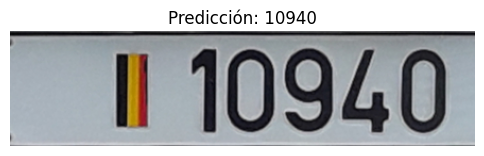

[images101.jpg] Detectado: 82132


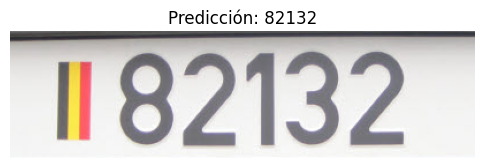

[images102.jpg] Detectado: 3864E


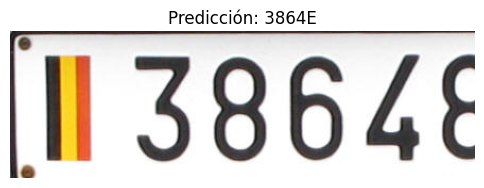

[images103.jpg] Detectado: 10935


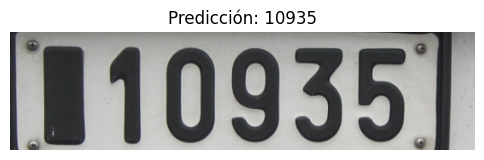


SUMMARY
images10.jpg                   → ---
images100.jpg                  → 10940
images101.jpg                  → 82132
images102.jpg                  → 3864E
images103.jpg                  → 10935


In [28]:
import os

# Test on a few samples
TEST_DIR = '../data/processed/test_samples'

if os.path.exists(TEST_DIR):
    # Filtramos solo imágenes para evitar errores con carpetas ocultas
    test_images = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))][:5]
    
    results = []
    for img_path in test_images:
        # --- CORRECCIÓN: Quitamos "debug=True" ---
        result = predict_plate_hybrid(img_path)
        results.append((os.path.basename(img_path), result))
    
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    for img_name, text in results:
        # Si result es None (no detectó), ponemos un texto
        display_text = text if text else "---"
        print(f"{img_name:30s} → {display_text}")
else:
    print(f"Test directory not found: {TEST_DIR}")

📸 Iniciando prueba rápida con 9 imágenes (de un total de 190)...

⚠️ Solo se detectó ruido en images10.jpg
[images100.jpg] Detectado: 10940


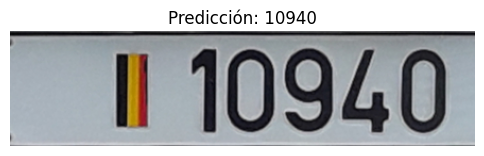

[images101.jpg] Detectado: 82132


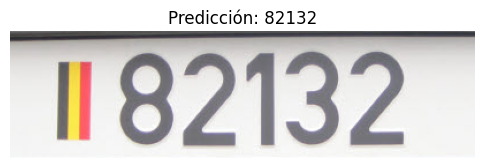

[images102.jpg] Detectado: 3864E


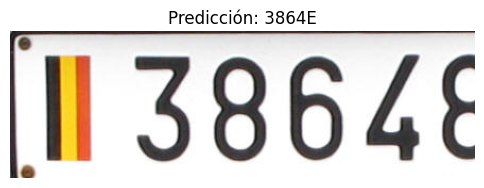

[images103.jpg] Detectado: 10935


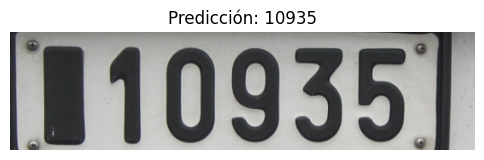

[images104.jpg] Detectado: IR18700


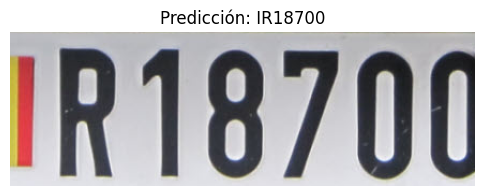

[images105.jpg] Detectado: DIIRIBAA


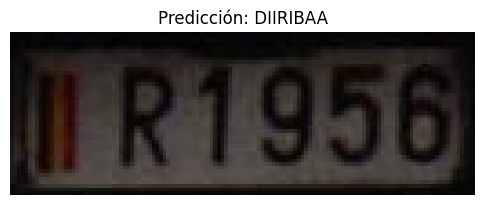

[images106.jpg] Detectado: 589


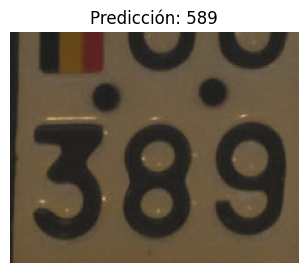

[images107.jpg] Detectado: 00


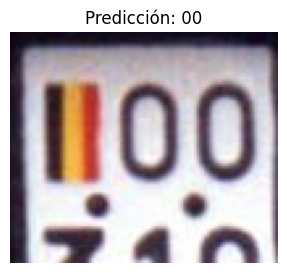


       RESUMEN FINAL


,Archivo,Placa Detectada
0,images10.jpg,---
1,images100.jpg,10940
2,images101.jpg,82132
3,images102.jpg,3864E
4,images103.jpg,10935
5,images104.jpg,IR18700
6,images105.jpg,DIIRIBAA
7,images106.jpg,589
8,images107.jpg,00


In [ ]:
import glob
import pandas as pd

# 1. Configuración
TEST_DIR = '../data/processed/test_samples'
extensions = ['*.jpg', '*.jpeg', '*.png']
test_images = []

for ext in extensions:
    test_images.extend(glob.glob(os.path.join(TEST_DIR, ext)))
test_images.sort()

test_sample = test_images[:9] 

print(f"Iniciando prueba rápida con {len(test_sample)} imágenes (de un total de {len(test_images)})...\n")

# 2. Ejecución
summary = []

for img_path in test_sample:
    try:
        # Llamada a la función nueva (sin debug=True, ya no es necesario)
        result = predict_plate_hybrid(img_path) 
        
        summary.append({
            "Archivo": os.path.basename(img_path),
            "Placa Detectada": result if result else "---"
        })
    except Exception as e:
        print(f"Error en {img_path}: {e}")

# 3. Tabla de Resultados
print("\n" + "="*40)
print("       RESUMEN FINAL")
print("="*40)
df_final = pd.DataFrame(summary)
from IPython.display import display
display(df_final)